# Exploring Dandiset 001195: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State

> **Note**: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify all analyses independently.

## Overview

This notebook provides an introduction to [DANDI:001195/0.250408.1733](https://dandiarchive.org/dandiset/001195/0.250408.1733), which contains electrophysiological recordings and calcium imaging data supporting the research on dorsal raphe nucleus (DRN) dopamine neurons and their projections to various brain regions.

The dataset examines how DRN dopamine projections to three distinct brain regions - bed nucleus of the stria terminalis (BNST), central amygdala (CeA), and posterior basolateral amygdala (BLP) - mediate different aspects of social behavior and affective states.

In this notebook, we will:

1. Explore the Dandiset metadata
2. Browse the available NWB files 
3. Examine the structure of intracellular electrophysiology recordings
4. Visualize current-clamp response data
5. Compare stimulus and response relationships

## Required Packages

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
import pandas as pd
from datetime import datetime

## Exploring Dandiset Metadata

In [2]:
# Initialize DANDI client and get metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001195", "0.250408.1733")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"DOI: {metadata['doi']}")
print(f"Version: {metadata['version']}")

Dandiset name: Separable Dorsal Raphe Dopamine Projections Mediate the Facets of Loneliness-like State
Dandiset URL: https://dandiarchive.org/dandiset/001195/0.250408.1733
DOI: 10.48324/dandi.001195/0.250408.1733
Version: 0.250408.1733


Let's look at key metadata fields that describe the research focus:

In [3]:
# Display subject information
print("About:")
for item in metadata.get('about', []):
    print(f"- {item.get('name', 'N/A')}")

print("\nKeywords:")
for keyword in metadata.get('keywords', []):
    print(f"- {keyword}")

print("\nStudy Target Summary:")
for target in metadata.get('studyTarget', []):
    # Truncate long descriptions for display
    description = target[:200] + "..." if len(target) > 200 else target
    print(f"- {description}")

About:
- dorsal raphe nucleus (DRN)
- Central Amygdala (CeA)
- Bed Nucleus of the Stria Terminalis (BNST)
- Posterior Basolateral Amygdala (BLP)
- social isolation

Keywords:
- optogenetics
- behavior videos
- calcium imaging
- electrophysiology
- Social Isolation
- Social Motivation
- mouse behavior
- behavioral neuroscience
- mouse model
- Dorsal Raphe Nucleus (DRN)
- Dopamine neurons

Study Target Summary:
- Affiliative social connections facilitate well-being and survival in numerous species. Engaging in social interactions requires positive or negative motivational drive, elicited through coordinated ac...


## Exploring NWB Files in the Dandiset

In [4]:
# Get a list of all assets
assets = list(dandiset.get_assets())
print(f"Total number of assets: {len(assets)}")

# Filter for NWB files
nwb_files = [asset for asset in assets if asset.path.endswith('.nwb')]
print(f"Number of NWB files: {len(nwb_files)}")

# Display the first 10 NWB files
print("\nSample of NWB files:")
for i, nwb_file in enumerate(nwb_files[:10]):
    print(f"{i+1}. {nwb_file.path}")

Total number of assets: 230
Number of NWB files: 189

Sample of NWB files:
1. sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb
2. sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb
3. sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb
4. sub-23/sub-23_ses-20150324T154615_slice-slice-2_cell-B2_icephys.nwb
5. sub-23/sub-23_ses-20150324T152016_slice-slice-2_cell-B1_icephys.nwb
6. sub-235/sub-235_ses-20200921T150553_slice-slice-1_cell-C5_icephys.nwb
7. sub-235/sub-235_ses-20200921T131057_slice-slice-1_cell-C1_icephys.nwb
8. sub-235/sub-235_ses-20200921T164032_slice-slice-2_cell-C8_icephys.nwb
9. sub-235/sub-235_ses-20200921T134852_slice-slice-1_cell-C2_icephys.nwb
10. sub-235/sub-235_ses-20200921T172736_slice-slice-2_cell-C10_icephys.nwb


Let's categorize the files based on their naming patterns to understand the data organization:

In [5]:
# Extract information from filenames
file_info = []
for asset in nwb_files:
    parts = asset.path.split('/')
    filename = parts[-1]
    components = filename.split('_')
    
    subject_id = components[0] if len(components) > 0 else 'unknown'
    session_id = components[1] if len(components) > 1 else 'unknown'
    remaining = '_'.join(components[2:]) if len(components) > 2 else 'unknown'
    
    file_info.append({
        'path': asset.path,
        'subject_id': subject_id,
        'session_id': session_id,
        'details': remaining,
        'size_bytes': asset.size
    })

# Convert to DataFrame for analysis
df_files = pd.DataFrame(file_info)

# Show distribution by subject
subject_counts = df_files['subject_id'].value_counts()
print("Number of files per subject:")
print(subject_counts.head(10))

Number of files per subject:
subject_id
sub-in-vivo-9    17
sub-in-vivo-5    16
sub-4481         13
sub-235          11
sub-5013         11
sub-C145         10
sub-5196         10
sub-C141          9
sub-235-cage      7
sub-C150          7
Name: count, dtype: int64


## Loading and Examining an Intracellular Electrophysiology Recording

Let's load one of the NWB files to explore its structure. We'll examine the intracellular electrophysiology recording (icephys) data.

In [6]:
# Select an NWB file to examine
file_to_examine = "sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb"

# Find the asset by path
asset = next(dandiset.get_assets_by_glob(file_to_examine))
url = asset.download_url

# Use remfile to stream the data rather than downloading it
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Let's examine the basic data structure and metadata of this NWB file:

In [7]:
# Print basic information about the file
print(f"Session ID: {nwb.identifier}")
print(f"Session Description: {nwb.session_description}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Experimenter: {nwb.experimenter}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")

# Subject information
subject = nwb.subject
print("\nSubject Information:")
print(f"Subject ID: {subject.subject_id}")
print(f"Age: {subject.age}")
print(f"Sex: {subject.sex}")
print(f"Species: {subject.species}")
print(f"Genotype: {subject.genotype}")
print(f"Strain: {subject.strain}")
print(f"Description: {subject.description}")

Session ID: a18b081c-3b63-45df-b702-fc3640aef3de
Session Description: episodic stimulation
Session Start Time: 2015-03-24 13:41:14-07:00
Experimenter: ('Matthews, Gillian',)
Lab: Kay Tye Lab
Institution: Massachusetts Institute of Technology

Subject Information:
Subject ID: 23
Age: P302D
Sex: F
Species: Mus musculus
Genotype: heterozygote
Strain: DAT::Cre
Description: AAV5-DIO-ChR2-eYFP into DRN


### Exploring the Intracellular Electrophysiology Data Structure

In [8]:
# Get information about the electrodes used in the recording
print("Intracellular Electrodes:")
for electrode_id, electrode in nwb.icephys_electrodes.items():
    print(f"  {electrode_id}:")
    print(f"    Description: {electrode.description}")
    print(f"    Device: {electrode.device.name}")

# Examine the DANDI-specific metadata
if hasattr(nwb, 'lab_meta_data') and 'DandiIcephysMetadata' in nwb.lab_meta_data:
    dandi_meta = nwb.lab_meta_data['DandiIcephysMetadata']
    print("\nDANDI Icephys Metadata:")
    print(f"  Cell ID: {dandi_meta.cell_id}")
    print(f"  Slice ID: {dandi_meta.slice_id}")
    print(f"  Targeted Layer: {dandi_meta.targeted_layer}")
    print(f"  Inferred Layer: {dandi_meta.inferred_layer}")

Intracellular Electrodes:
  electrode-0:
    Description: no description
    Device: DeviceIcephys
  electrode-1:
    Description: no description
    Device: DeviceIcephys

DANDI Icephys Metadata:
  Cell ID: C1
  Slice ID: slice 1
  Targeted Layer: CeA
  Inferred Layer: CeA


Let's look at the structure of the acquisition (response) data:

In [9]:
# List the acquisition (response) data series
print("Acquisition (Response) Data Series:")
for i, (series_name, series) in enumerate(nwb.acquisition.items()):
    if i >= 5:  # Limit to first 5 for brevity
        print(f"  ... and {len(nwb.acquisition) - 5} more series")
        break
    print(f"  {series_name}:")
    print(f"    Type: {type(series).__name__}")
    print(f"    Description: {series.description[:100]}..." if len(series.description) > 100 else f"    Description: {series.description}")
    print(f"    Rate: {series.rate} Hz")
    print(f"    Unit: {series.unit}")

Acquisition (Response) Data Series:
  current_clamp-response-01-ch-0:
    Type: CurrentClampSeries
    Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: volts
  current_clamp-response-01-ch-1:
    Type: CurrentClampSeries
    Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: volts
  current_clamp-response-02-ch-0:
    Type: CurrentClampSeries
    Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: volts
  current_clamp-response-02-ch-1:
    Type: CurrentClampSeries
    Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: volts
  current_clamp-response-03-ch-0:
    Type: CurrentClampSeries
    Description: Response to: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    U

And let's examine the stimulus data:

In [10]:
# List the stimulus data series
print("Stimulus Data Series:")
for i, (series_name, series) in enumerate(nwb.stimulus.items()):
    if i >= 5:  # Limit to first 5 for brevity
        print(f"  ... and {len(nwb.stimulus) - 5} more series")
        break
    print(f"  {series_name}:")
    print(f"    Type: {type(series).__name__}")
    print(f"    Description: {series.description[:100]}..." if len(series.description) > 100 else f"    Description: {series.description}")
    print(f"    Rate: {series.rate} Hz")
    print(f"    Unit: {series.unit}")

Stimulus Data Series:
  stimulus-01-ch-0:
    Type: CurrentClampStimulusSeries
    Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: amperes
  stimulus-01-ch-1:
    Type: CurrentClampStimulusSeries
    Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: amperes
  stimulus-02-ch-0:
    Type: CurrentClampStimulusSeries
    Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: amperes
  stimulus-02-ch-1:
    Type: CurrentClampStimulusSeries
    Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: amperes
  stimulus-03-ch-0:
    Type: CurrentClampStimulusSeries
    Description: Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
    Rate: 10000.0 Hz
    Unit: amperes
  ... and 81 more series


Let's look at the relationship between stimulus and recordings using the icephys tables:

In [11]:
# Look at the structure of intracellular recordings tables
print("Intracellular Recordings Table:")
try:
    icr_df = nwb.intracellular_recordings.to_dataframe()
    print(f"  Number of recordings: {len(icr_df)}")
except:
    print("  Could not convert to dataframe")

print("\nSimultaneous Recordings Table:")
try:
    sim_df = nwb.icephys_simultaneous_recordings.to_dataframe()
    print(f"  Number of simultaneous recording groups: {len(sim_df)}")
    print(f"  Columns: {sim_df.columns.tolist()}")
except:
    print("  Could not convert to dataframe")

print("\nSequential Recordings Table:")
try:
    seq_df = nwb.icephys_sequential_recordings.to_dataframe()
    print(f"  Number of sequential recording groups: {len(seq_df)}")
    print(f"  Columns: {seq_df.columns.tolist()}")
except:
    print("  Could not convert to dataframe")

Intracellular Recordings Table:
  Number of recordings: 86

Simultaneous Recordings Table:


  Number of simultaneous recording groups: 43
  Columns: ['recordings']

Sequential Recordings Table:


  Number of sequential recording groups: 5
  Columns: ['simultaneous_recordings', 'stimulus_type']


## Visualizing the Electrophysiology Data

Now let's visualize the current clamp responses to different stimulus intensities. We'll examine the data from specific episodes.

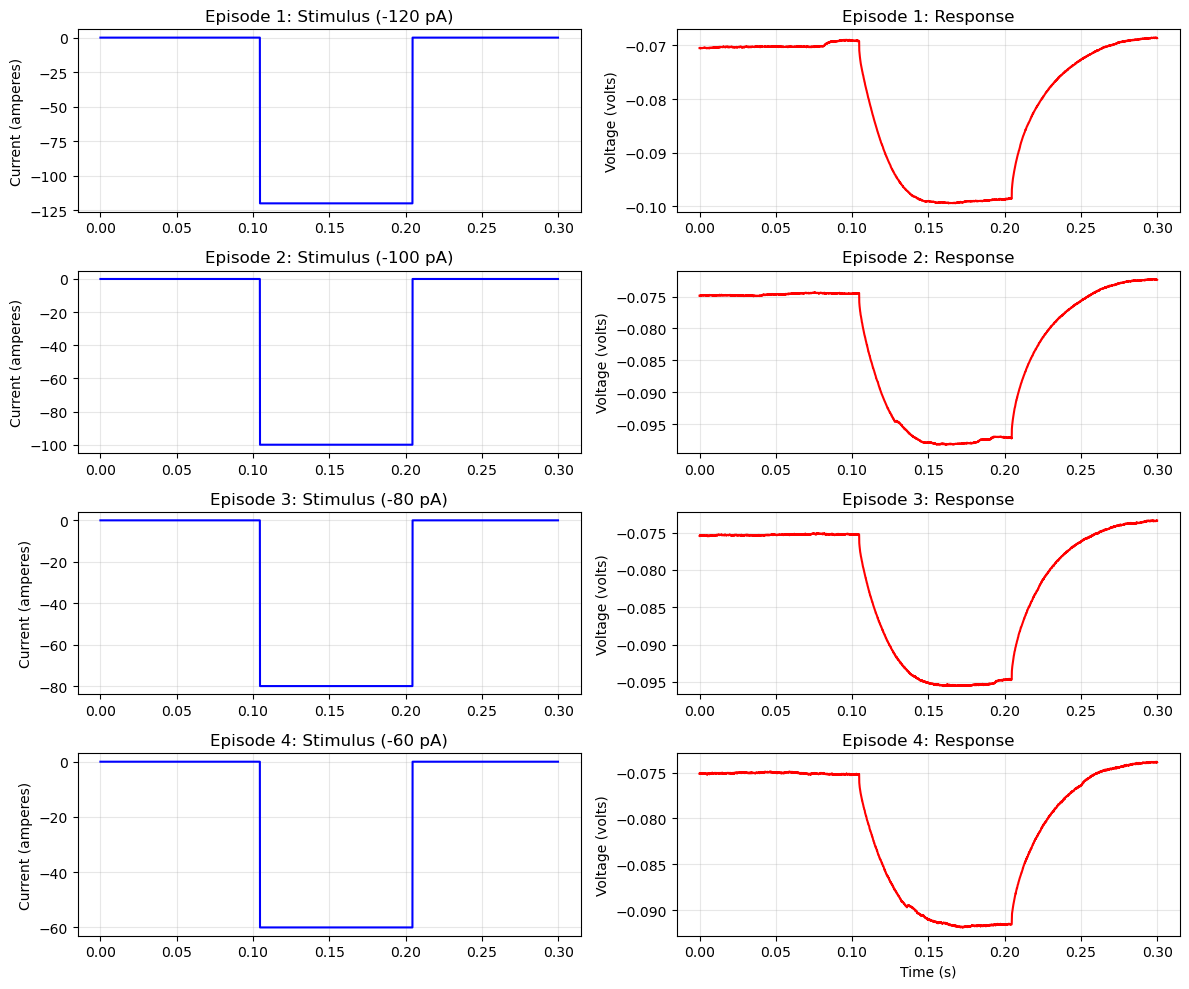

In [12]:
# Function to extract data from a specific stimulus-response pair
def extract_stimulus_response_data(episode_num, channel=0):
    stim_name = f"stimulus-{episode_num:02d}-ch-{channel}"
    resp_name = f"current_clamp-response-{episode_num:02d}-ch-{channel}"
    
    if stim_name in nwb.stimulus and resp_name in nwb.acquisition:
        stimulus = nwb.stimulus[stim_name]
        response = nwb.acquisition[resp_name]
        
        # Get data and apply conversion
        stim_data = stimulus.data[:]
        resp_data = response.data[:] * response.conversion
        
        # Create time array
        dt = 1.0 / stimulus.rate
        time = np.arange(len(stim_data)) * dt
        
        return time, stim_data, resp_data, stimulus.unit, response.unit
    else:
        return None, None, None, None, None

# Plot the first few episodes
plt.figure(figsize=(12, 10))

# Plot multiple episodes
for i in range(1, 5):  # First 4 episodes
    time, stim_data, resp_data, stim_unit, resp_unit = extract_stimulus_response_data(i)
    
    if time is not None:
        # Calculate current value based on episode number
        current_value = (i-1) * 20 - 120  # -120pA baseline with 20pA steps
        
        # Create subplots
        plt.subplot(4, 2, 2*i-1)
        plt.plot(time, stim_data, 'b-')
        plt.title(f"Episode {i}: Stimulus ({current_value} pA)")
        plt.ylabel(f"Current ({stim_unit})")
        plt.grid(True, alpha=0.3)
        
        plt.subplot(4, 2, 2*i)
        plt.plot(time, resp_data, 'r-')
        plt.title(f"Episode {i}: Response")
        plt.ylabel(f"Voltage ({resp_unit})")
        plt.grid(True, alpha=0.3)
        
        # Only add x-label to the bottom plots
        if i == 4:
            plt.xlabel("Time (s)")
    else:
        print(f"Data for episode {i} not found")

plt.tight_layout()
plt.show()

Let's create a comparison plot that shows the different response patterns across multiple current steps:

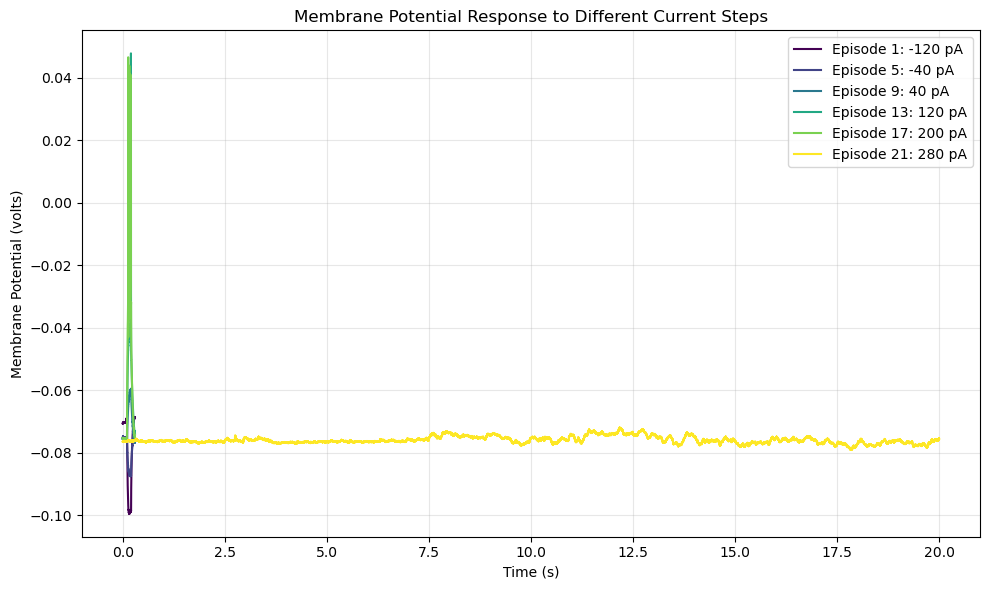

In [13]:
# Plot responses from multiple episodes on the same axes
plt.figure(figsize=(10, 6))

# Select episodes with different current steps to visualize
episodes_to_plot = [1, 5, 9, 13, 17, 21]  # Different current values
colors = plt.cm.viridis(np.linspace(0, 1, len(episodes_to_plot)))

for idx, episode in enumerate(episodes_to_plot):
    time, _, resp_data, _, resp_unit = extract_stimulus_response_data(episode)
    
    if time is not None:
        current_value = (episode-1) * 20 - 120  # Calculate current value
        plt.plot(time, resp_data, color=colors[idx], 
                 label=f"Episode {episode}: {current_value} pA")
    
plt.xlabel('Time (s)')
plt.ylabel(f'Membrane Potential ({resp_unit})')
plt.title('Membrane Potential Response to Different Current Steps')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analyzing Response Properties

Now let's analyze the voltage responses to different current injections to better understand the electrophysiological properties of this cell:

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


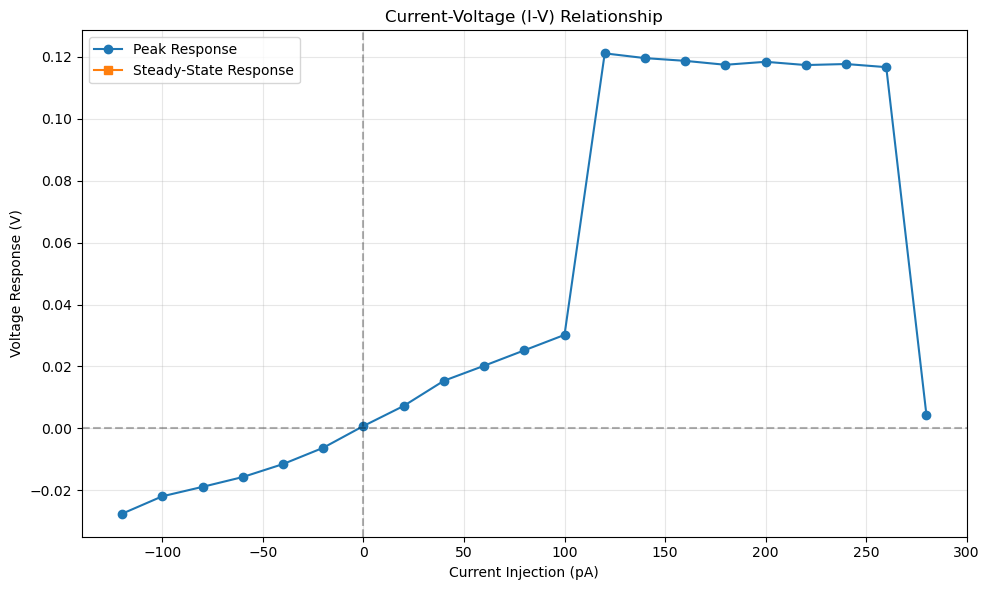

In [14]:
# Function to extract key metrics from responses
def extract_response_metrics(max_episodes=20):
    """Extract key metrics from current clamp responses"""
    
    # Initialize arrays to store results
    current_values = []
    peak_values = []
    steady_state_values = []
    
    for episode in range(1, max_episodes+1):
        time, stim_data, resp_data, _, _ = extract_stimulus_response_data(episode)
        
        if time is None or resp_data is None:
            continue
        
        # Current value for this episode
        current_value = (episode-1) * 20 - 120
        
        # Assuming stimulus is applied from 0.4s to 1.4s (based on visualization)
        # Find indices for baseline, peak response, and steady-state
        baseline_idx = slice(int(0.1 * len(time)), int(0.4 * len(time)))
        response_idx = slice(int(0.4 * len(time)), int(1.4 * len(time)))
        steady_idx = slice(int(1.3 * len(time)), int(1.4 * len(time)))
        
        # Calculate metrics
        baseline_v = np.mean(resp_data[baseline_idx])
        response_v = resp_data[response_idx]
        
        # For positive currents, find max (depolarization)
        # For negative currents, find min (hyperpolarization)
        if current_value >= 0:
            peak_v = np.max(response_v) - baseline_v
        else:
            peak_v = np.min(response_v) - baseline_v
        
        # Calculate steady-state response
        steady_v = np.mean(resp_data[steady_idx]) - baseline_v
        
        # Store results
        current_values.append(current_value)
        peak_values.append(peak_v)
        steady_state_values.append(steady_v)
    
    return current_values, peak_values, steady_state_values

# Extract metrics and create I-V curve
currents, peaks, steady_states = extract_response_metrics(max_episodes=25)

# Plot I-V relationship
plt.figure(figsize=(10, 6))
plt.plot(currents, peaks, 'o-', label='Peak Response')
plt.plot(currents, steady_states, 's-', label='Steady-State Response')

# Add zero lines
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.xlabel('Current Injection (pA)')
plt.ylabel('Voltage Response (V)')
plt.title('Current-Voltage (I-V) Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Let's also analyze the spike activity in response to different current injections:

/tmp/ipykernel_10861/2474910293.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


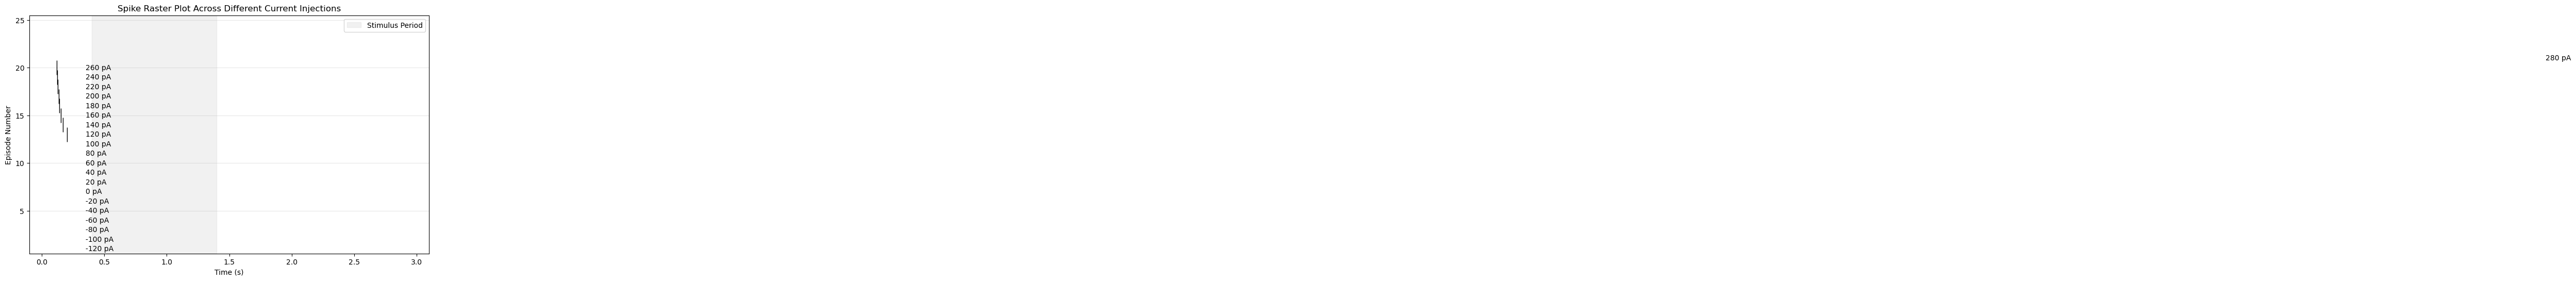

In [15]:
# Function to detect action potentials in voltage traces
def detect_spikes(voltage, time, threshold=0.02, min_interval=0.001):
    """
    Detect spikes (action potentials) in a voltage trace
    
    Parameters:
    voltage - voltage trace
    time - corresponding time points
    threshold - voltage threshold for spike detection (V)
    min_interval - minimum time between spikes (s)
    
    Returns:
    spike_times - times of detected spikes
    """
    # Compute derivative to detect rapid voltage changes
    dv = np.diff(voltage)
    
    # Find threshold crossings with high dv/dt
    threshold_crossings = []
    for i in range(1, len(dv)-1):
        if dv[i] > threshold and voltage[i] > -0.03:  # Typical AP threshold
            threshold_crossings.append(i)
    
    # Filter out multiple crossings for the same spike
    spike_indices = []
    if len(threshold_crossings) > 0:
        spike_indices = [threshold_crossings[0]]
        for i in range(1, len(threshold_crossings)):
            if time[threshold_crossings[i]] - time[spike_indices[-1]] > min_interval:
                spike_indices.append(threshold_crossings[i])
    
    return [time[i] for i in spike_indices]

# Create a raster plot of spikes for different current injections
plt.figure(figsize=(10, 6))

# Track if we found any spikes
spikes_found = False

# Analyze episodes
for episode in range(1, 25):  # Analyze first 25 episodes
    time, _, resp_data, _, _ = extract_stimulus_response_data(episode)
    
    if time is None or resp_data is None:
        continue
    
    # Calculate current value
    current_value = (episode-1) * 20 - 120
    
    # Detect spikes
    spike_times = detect_spikes(resp_data, time)
    
    # Plot spike times as vertical lines
    if spike_times:
        spikes_found = True
        plt.plot(spike_times, [episode] * len(spike_times), 'k|', ms=20, mew=1)
    
    # Annotate with current value
    plt.text(max(time) + 0.05, episode, f"{current_value} pA", va='center')

# Indicate stimulus period
plt.axvspan(0.4, 1.4, color='lightgray', alpha=0.3, label='Stimulus Period')

plt.xlabel('Time (s)')
plt.ylabel('Episode Number')
plt.title('Spike Raster Plot Across Different Current Injections')
plt.xlim(-0.1, 3.1)
plt.ylim(0.5, 25.5)
plt.grid(True, alpha=0.3, axis='y')

if not spikes_found:
    plt.text(1.5, 12.5, "No spikes detected", fontsize=14, ha='center')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Finally, let's look at the firing frequency vs. current intensity (F-I curve) for our cell:

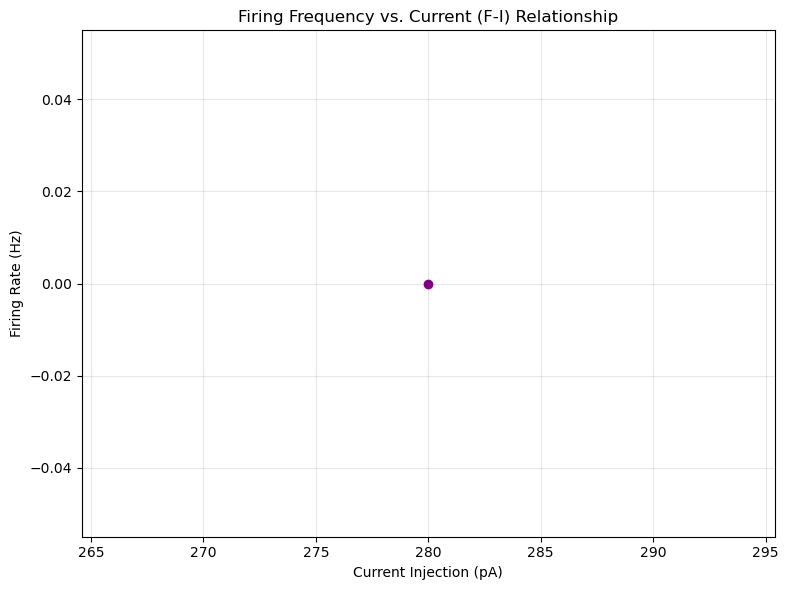

In [16]:
# Function to calculate firing frequency for each current injection
def calculate_firing_rates(max_episodes=25):
    """Calculate firing rates for different current injections"""
    
    current_values = []
    firing_rates = []
    
    for episode in range(1, max_episodes+1):
        time, _, resp_data, _, _ = extract_stimulus_response_data(episode)
        
        if time is None or resp_data is None:
            continue
        
        # Calculate current value
        current_value = (episode-1) * 20 - 120
        
        # Detect spikes during stimulus period (0.4s to 1.4s)
        stim_start_idx = np.argmin(np.abs(time - 0.4))
        stim_end_idx = np.argmin(np.abs(time - 1.4))
        
        stim_time = time[stim_start_idx:stim_end_idx]
        stim_resp = resp_data[stim_start_idx:stim_end_idx]
        
        if len(stim_time) > 0:
            spike_times = detect_spikes(stim_resp, stim_time)
            
            # Calculate firing rate (Hz)
            stim_duration = stim_time[-1] - stim_time[0]
            firing_rate = len(spike_times) / stim_duration if stim_duration > 0 else 0
            
            current_values.append(current_value)
            firing_rates.append(firing_rate)
    
    return current_values, firing_rates

# Calculate firing rates
current_values, firing_rates = calculate_firing_rates()

# Plot F-I curve
plt.figure(figsize=(8, 6))
plt.plot(current_values, firing_rates, 'o-', color='purple')
plt.xlabel('Current Injection (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Frequency vs. Current (F-I) Relationship')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we explored Dandiset 001195, which contains electrophysiological recordings from dorsal raphe nucleus (DRN) dopamine neurons and their projections to various brain regions. We:

1. Examined the metadata to understand the scientific context of the dataset
2. Explored the structure of the NWB files within the dandiset
3. Analyzed intracellular electrophysiology data, focusing on current-clamp recordings
4. Visualized responses to different stimulus intensities
5. Created analysis plots showing current-voltage relationships and spiking patterns

Future explorations could include:
- Comparing recordings across different brain regions (BNST, CeA, BLP)
- Analyzing calcium imaging data included in the dataset
- Examining response differences between experimental conditions
- Correlating electrophysiological properties with behavioral outcomes